In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import tensorflow
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_benih = '/content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/'

In [ ]:
kelas = ['broken', 'discolored', 'pure', 'silkcut']
kelas

['broken', 'discolored', 'pure', 'silkcut']

In [ ]:
def get_data(data_dir):
    size = (224,224)
    label = 0
    x = []
    y = []
    for folder in kelas:
        print("Loading {}".format(data_dir+folder))
        for pic in tqdm(glob.glob(data_dir + folder + '/*')):
            im = cv2.imread(pic)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (size))
            im = np.array(im)
            x.append(im)
            y.append(label)
        label+=1
    x = np.array(x, dtype = 'float32')
    y = np.array(y, dtype = 'int32')
    return x,y

In [ ]:
x_train, y_train = get_data(path_benih + 'train/')
x_test, y_test = get_data(path_benih + 'test/')

Loading /content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/train/broken


100%|██████████| 1000/1000 [00:02<00:00, 351.18it/s]


Loading /content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/train/discolored


100%|██████████| 1000/1000 [00:02<00:00, 347.36it/s]


Loading /content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/train/pure


100%|██████████| 1000/1000 [00:03<00:00, 326.62it/s]


Loading /content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/train/silkcut


100%|██████████| 1000/1000 [00:03<00:00, 325.10it/s]


Loading /content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/test/broken


100%|██████████| 250/250 [00:00<00:00, 365.89it/s]


Loading /content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/test/discolored


100%|██████████| 250/250 [00:00<00:00, 383.64it/s]


Loading /content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/test/pure


100%|██████████| 250/250 [00:00<00:00, 360.44it/s]


Loading /content/drive/My Drive/Penelitian Andyka/Kualitass/dataset/test/silkcut


100%|██████████| 250/250 [00:00<00:00, 323.46it/s]


In [ ]:
x_train/=255.
x_test/=255.

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [ ]:
vgg = VGG19(input_shape = (224, 224, 3), include_top=False, weights="imagenet")
vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def arsitektur():
  x=Flatten()(vgg.output)
  x=Dense(1024, activation='relu')(x)
  x=Dropout(0.4)(x)
  x=Dense(512, activation='relu')(x)
  x=Dropout(0.4)(x)
  prediksi=Dense(len(kelas), activation='softmax')(x)
  model=Model(inputs=vgg.input, outputs=prediksi)

  return model

In [ ]:
model = arsitektur()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def get_model_name(k):
  return 'model_'+str(k)

In [ ]:
akurasi_val_data=[]
CV=[]
waktu=[]

LOSS=[]
VAL_LOSS=[]
ACCURACY=[]
VAL_ACCURACY=[]

fold_var = 1
max_epoch = 64
batch_size = 32
lr = 0.00001

save_dir = '/content/drive/My Drive/Penelitian Andyka/Kualitass/save_models/percobaan/'

In [ ]:
kf = StratifiedKFold(n_splits=5)
for train_index, val_index in kf.split(x_train, y_train):
  print("---------- FOLD KE- {} ----------".format(fold_var))
  x_training, y_training = x_train[train_index], y_train[train_index]
  x_validasi, y_validasi = x_train[val_index], y_train[val_index]

  y_training = to_categorical(y_training, num_classes=4)
  y_validasi = to_categorical(y_validasi, num_classes=4)

  model.compile(optimizer=Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # min_delta (perubahan minimal), patience (jumlah epoch tanpa perbaikan)
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='auto')
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var),
                               monitor='accuracy', verbose=1,
                               save_best_only=True, mode='max')
  callback_list = [early_stop, checkpoint]

  start = datetime.datetime.now()
  hist = model.fit(x_training, y_training,
                   epochs=max_epoch,
                   batch_size=batch_size,
                   callbacks=callback_list,
                   validation_data = (x_validasi, y_validasi))
  end = datetime.datetime.now()
  jam = end - start

  model = load_model(save_dir+"model_"+str(fold_var))

  predict = model.predict(x_validasi)
  predict = np.argmax(predict, axis=1)
  labels = np.argmax(y_validasi, axis=1)
  print(classification_report(labels, predict, target_names = ['Broken (Class 0)','Discolored (Class 1)', 'Pure (Class 2)', 'Silkcut (Class 3)']))
  print('Waktu Pelatihan Data : ', jam, '\n\n')
  acc = accuracy_score(labels, predict)

  waktu.append(jam)
  akurasi_val_data.append(acc)
  LOSS.append(hist.history['loss'])
  ACCURACY.append(hist.history['accuracy'])
  VAL_LOSS.append(hist.history['val_loss'])
  VAL_ACCURACY.append(hist.history['val_accuracy'])
  CV.append('CV-'+str(fold_var))

  clear_session()
  fold_var+=1

---------- FOLD KE- 1 ----------
Epoch 1/64
100/100 [==============================] - ETA: 0s - loss: 1.4617 - accuracy: 0.3091
Epoch 1: accuracy improved from -inf to 0.30906, saving model to /content/drive/My Drive/Penelitian Andyka/Kualitass/save_models/percobaan/model_1
100/100 [==============================] - 31s 237ms/step - loss: 1.4617 - accuracy: 0.3091 - val_loss: 1.2396 - val_accuracy: 0.4963
Epoch 2/64
100/100 [==============================] - ETA: 0s - loss: 1.2393 - accuracy: 0.4409
Epoch 2: accuracy improved from 0.30906 to 0.44094, saving model to /content/drive/My Drive/Penelitian Andyka/Kualitass/save_models/percobaan/model_1
100/100 [==============================] - 23s 235ms/step - loss: 1.2393 - accuracy: 0.4409 - val_loss: 1.1152 - val_accuracy: 0.5663
Epoch 3/64
100/100 [==============================] - ETA: 0s - loss: 1.1317 - accuracy: 0.5063
Epoch 3: accuracy improved from 0.44094 to 0.50625, saving model to /content/drive/My Drive/Penelitian Andyka/Kual

In [ ]:
print(akurasi_val_data)
print(CV)
print(waktu)

print(LOSS)
print(VAL_LOSS)
print(ACCURACY)
print(VAL_ACCURACY)

[0.815, 0.96, 0.9525, 0.975, 0.9875]
['CV-1', 'CV-2', 'CV-3', 'CV-4', 'CV-5']
[datetime.timedelta(seconds=1333, microseconds=43934), datetime.timedelta(seconds=363, microseconds=546055), datetime.timedelta(seconds=188, microseconds=255521), datetime.timedelta(seconds=348, microseconds=596124), datetime.timedelta(seconds=224, microseconds=258696)]
[[1.4617420434951782, 1.2393255233764648, 1.1316944360733032, 1.0278502702713013, 0.9675396084785461, 0.9085741639137268, 0.8663327097892761, 0.8273661136627197, 0.7910366654396057, 0.7594631314277649, 0.7281725406646729, 0.6970509886741638, 0.6891558766365051, 0.662339985370636, 0.6364343166351318, 0.6273466944694519, 0.596712589263916, 0.581109881401062, 0.5698019862174988, 0.5539196729660034, 0.5300010442733765, 0.5282722115516663, 0.5136584043502808, 0.5055818557739258, 0.488652765750885, 0.4757838547229767, 0.45929497480392456, 0.4450022578239441, 0.4377071261405945, 0.4279140830039978, 0.4202336072921753, 0.4000665247440338, 0.4015392065

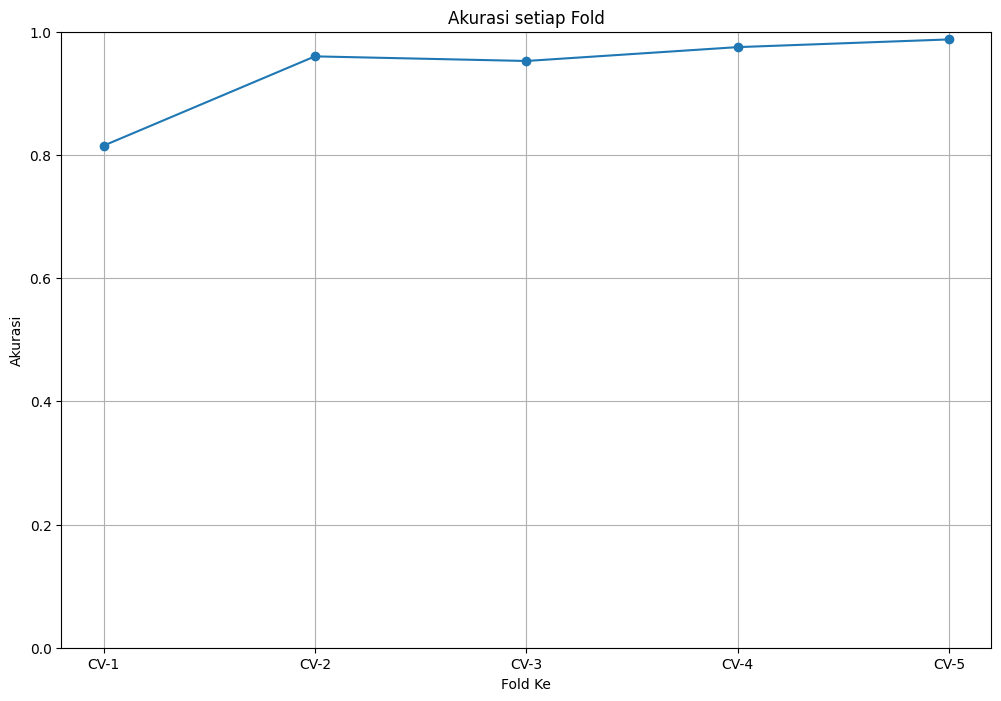

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(CV, akurasi_val_data, marker='o')
plt.title('Akurasi setiap Fold')
plt.xlabel('Fold Ke')
plt.ylabel('Akurasi')
plt.ylim((0., 1))
plt.grid()
plt.show()

In [ ]:
def visualisasi_fit(judul, n_train, n_val):
  fig, ax = plt.subplots(3,2,constrained_layout=True, figsize=(15,10))
  index=0
  for i in range(3):
    for j in range(2):
      if j==0:
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
      else:
        if index==5:
          break
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
      ax[i,j].grid()
      ax[i,j].set_ylim((0., 1))
      ax[i,j].legend()
      index+=1

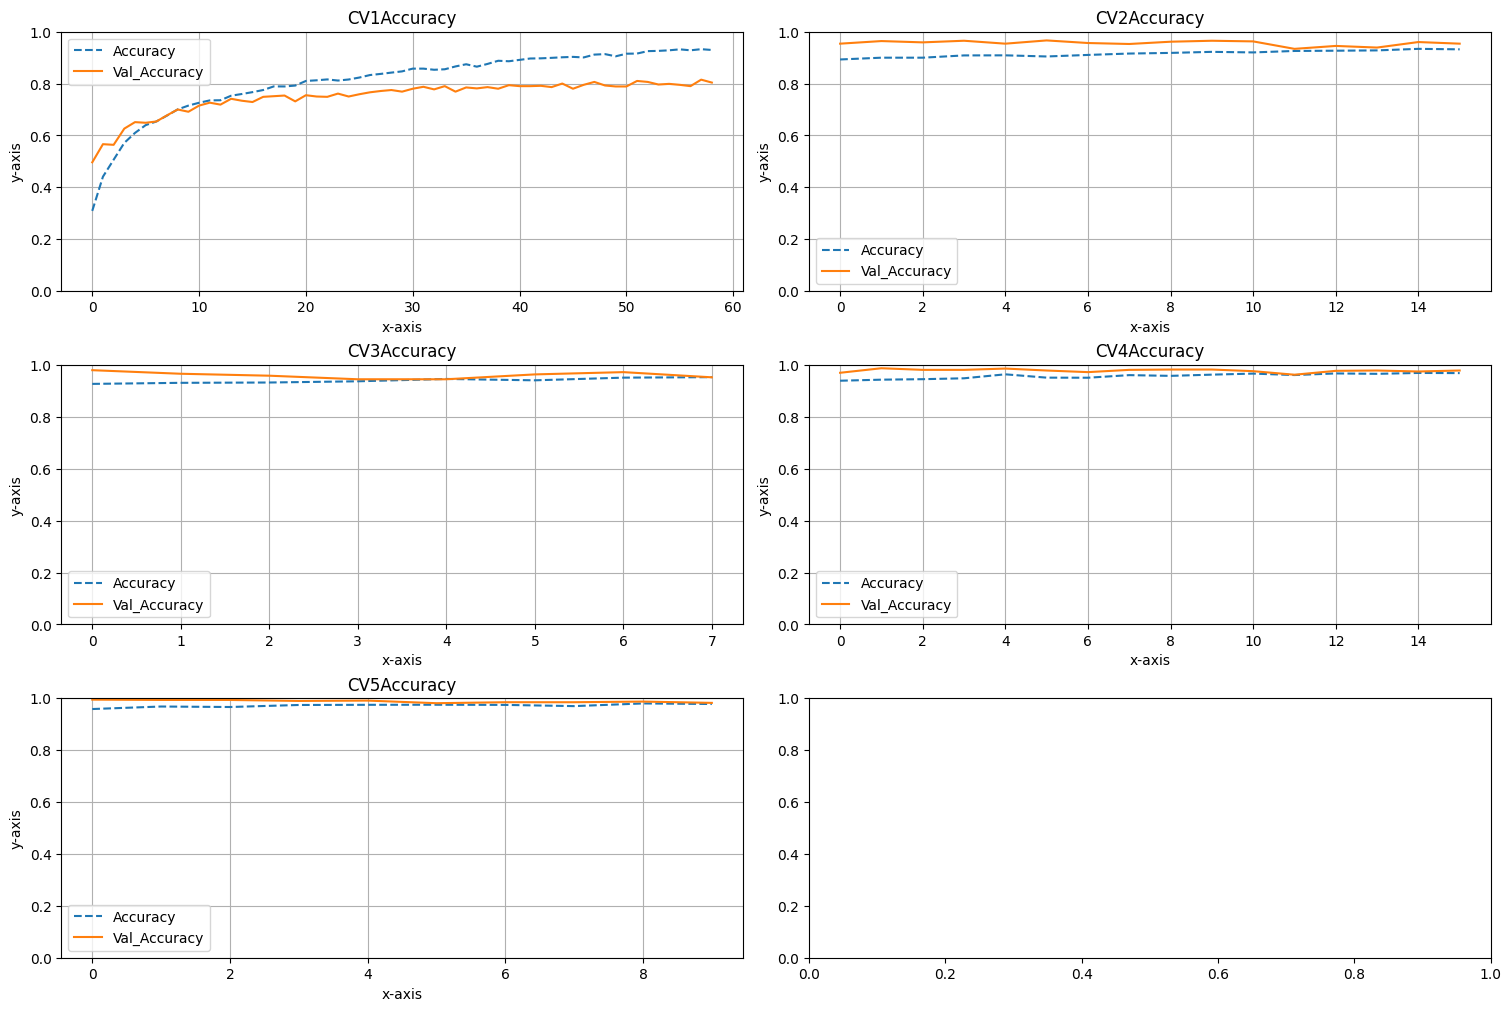

In [ ]:
vis_akurasi = visualisasi_fit('Accuracy', ACCURACY, VAL_ACCURACY)
vis_akurasi

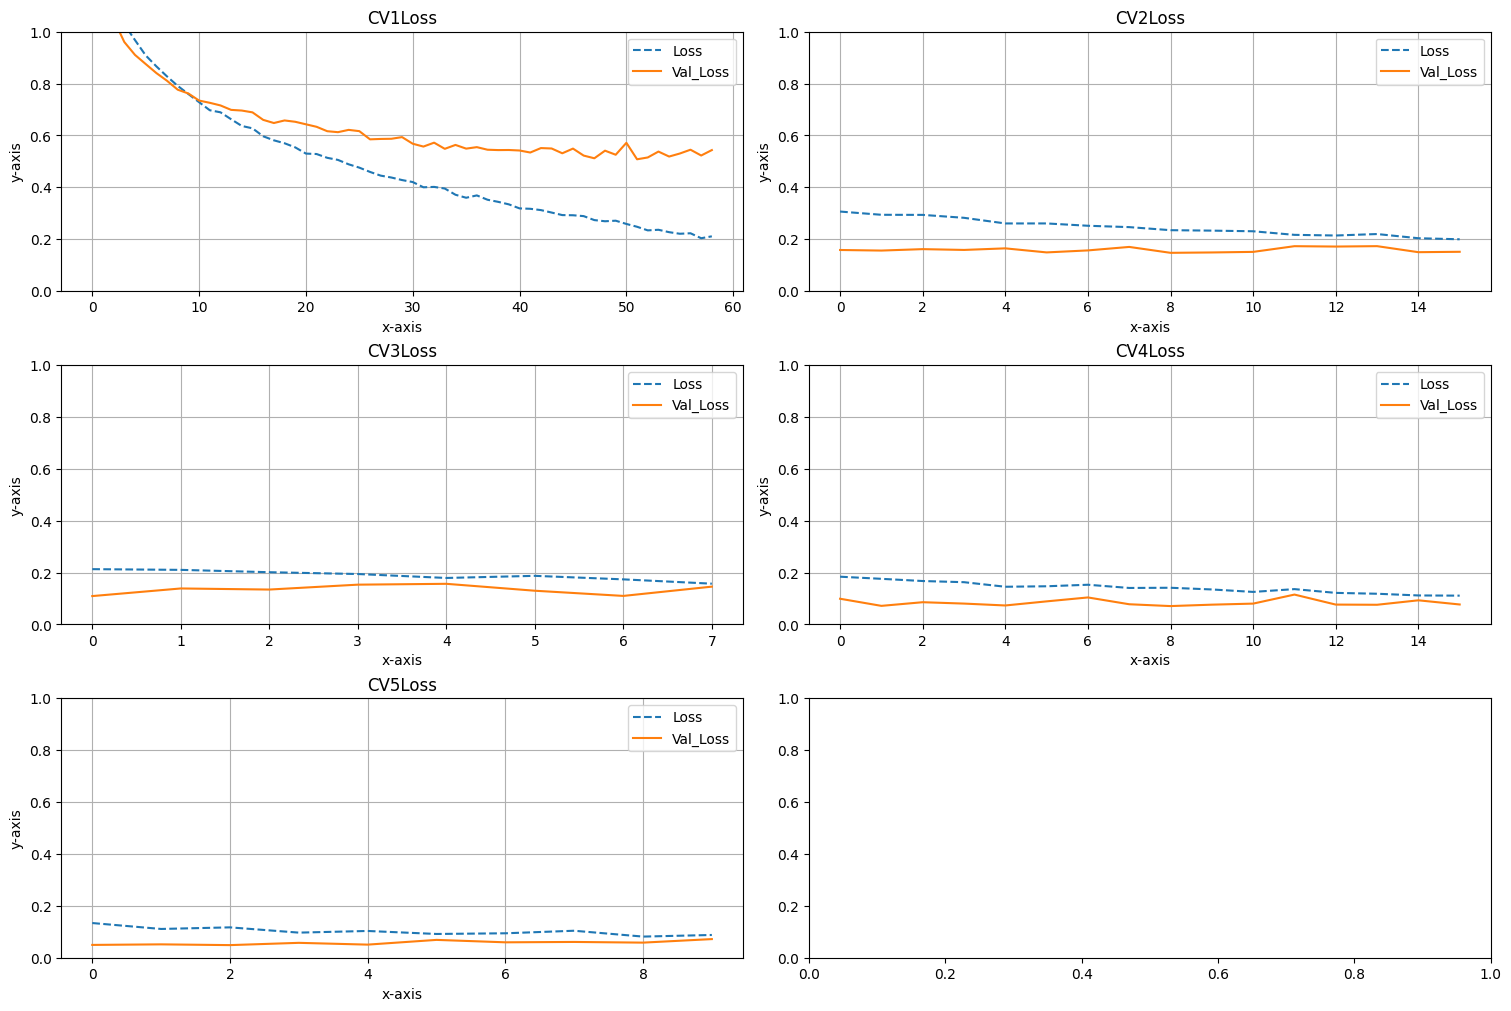

In [ ]:
vis_loss = visualisasi_fit('Loss', LOSS, VAL_LOSS)
vis_loss

In [ ]:
terbaik=[]
for i in range(5):
  nilai = (akurasi_val_data[i])
  terbaik.append(nilai)

In [ ]:
terbaik

[0.815, 0.96, 0.9525, 0.975, 0.9875]

In [ ]:
s=0
baik=1
for i, v in enumerate(terbaik):
  if v>s:
    s=v
    baik=i+1
  else:
    continue
print(baik, s)

5 0.9875


In [ ]:
model = load_model(save_dir+"model_"+str(baik))
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

32/32 [==============================] - 7s 207ms/step


In [ ]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred, average='micro')
rec_test = recall_score(y_test, y_pred, average='micro')
f1score_test = f1_score(y_test, y_pred, average='micro')

In [ ]:
print('Acc Test : ', acc_test)
print('Prec Test : ', prec_test)
print('Rec Test : ', rec_test)
print('F1-Score Test : ', f1score_test)

Acc Test :  0.817
Prec Test :  0.817
Rec Test :  0.817
F1-Score Test :  0.817


In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Broken (Class 0)','Discolored (Class 1)', 'Pure (Class 2)', 'Silkcut (Class 3)']))

                      precision    recall  f1-score   support

    Broken (Class 0)       0.88      0.81      0.84       250
Discolored (Class 1)       0.82      0.79      0.81       250
      Pure (Class 2)       0.93      0.82      0.87       250
   Silkcut (Class 3)       0.69      0.86      0.76       250

            accuracy                           0.82      1000
           macro avg       0.83      0.82      0.82      1000
        weighted avg       0.83      0.82      0.82      1000

